In [1]:
import h5py
import numpy as np
from scipy import linalg

/Users/atsushi/.pyenv/versions/anaconda3-5.1.0/envs/jupyter-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 直交表の読み出し
* https://hondou.homedns.org/pukiwiki/index.php?Python%20HDF5 で、直交表を　numpy.ndarray 形式で HDF5 ファイルにまとめた。
* それを読み出して使う
* 直交表について
$$
L_n(q^m) = OA (n, m, q, t)
$$
    * n : 大きさ、テスト回数
    * m : 因子数 = テストデータの項目数
    * q : 水準数 = テスト項目の値の種類
    * t : 強さ = テスト項目の組み合わせ数

In [2]:
    hdf5 = h5py.File("mypkg/oamatrix.hdf5", 'r')
    m=2
    q=3
    oa = hdf5["{}^{}".format(m,q)].value
    print(oa)
    hdf5.close()

[[0 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 0]]


# 直交表と最小自乗推定で、パラメータの寄与度を計算する

In [3]:
# 直交表の最終列に、{1,1,1,1}T を追加する。　⇒ 誤差というか、嵩上げされている得点の部分
# いったん転置して、最終行に {1,1,1,1} を付け足してから転置してもとに戻す
m = oa.T
fixed = np.array([np.ones(oa.shape[0])]);
print(m)
print (fixed)

                 
A = (np.concatenate( (m, fixed) )).T
B = np.array([10.0,70.0,80.0,90.0])
print ("A=\n{}".format(A))
print ("B={}".format(B))
# least squares
C, resid, rank, sigma = linalg.lstsq(A, B)
print ("C={}".format(C))
print ("resid={}".format(resid))
print ("rank={}".format(rank))
print ("sigma={}".format(sigma))


[[0 0 1 1]
 [0 1 0 1]
 [0 1 1 0]]
[[1. 1. 1. 1.]]
A=
[[0. 0. 0. 1.]
 [0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]]
B=[10. 70. 80. 90.]
C=[45. 35. 25. 10.]
resid=[]
rank=4
sigma=[2.73205081 1.         1.         0.73205081]


# 要因効果図の描画
* 要因効果図は、特に自前では計算せずに、seaborn の PairGrid を使って描画します
* seaborn では入力データは、Pandas の Data Form で定義します
* Data Form を作るためには、CSV などのデータソースを直接読み出すやり方と、numpy の　ndarray を Data Form に変換するやり方があります

    豚骨   魚介  鶏ガラ    得点    コスト
0  0.0  0.0  0.0  10.0  100.0
1  0.0  1.0  1.0  70.0  200.0
2  1.0  0.0  1.0  80.0  300.0
3  1.0  1.0  0.0  90.0  300.0


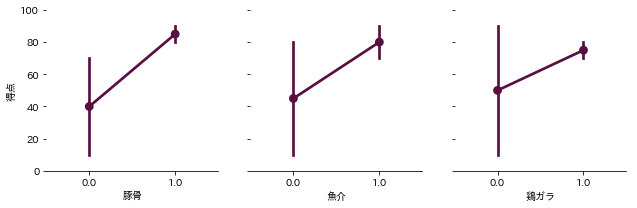

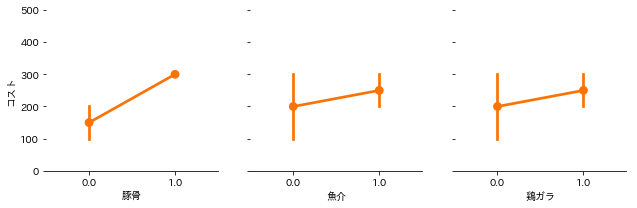

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 費用データ
D=np.array([100,200,300,300]);

# Pandas の data_frame を numpy の　ndarray から作成する
# (CSVの読み込みや、RDBでのSQL文の実行結果からも作ることができる)
data = np.concatenate( (oa.T, np.array([B]), np.array([D]) ) )
soup_frame = pd.DataFrame(data.T, columns=["豚骨", "魚介","鶏ガラ","得点","コスト"])
print (soup_frame)

# 素材と得点の関係
g1 = sns.PairGrid(soup_frame, y_vars="得点",
                 x_vars=["豚骨", "魚介", "鶏ガラ"],
                 size=3, aspect=1.0)

g1.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g1.set(ylim=(0, 100))
sns.despine(fig=g1.fig, left=True)

# 素材とコストの関係
g2 = sns.PairGrid(soup_frame, y_vars="コスト",
                 x_vars=["豚骨", "魚介", "鶏ガラ"],
                 size=3, aspect=1.0)

g2.map(sns.pointplot, color=sns.xkcd_rgb["orange"])
g2.set(ylim=(0, 500))
sns.despine(fig=g2.fig, left=True)

# 描画
plt.show()


# 実験計画に使える直交表

In [5]:
def createOA (hdf5, n, m, q) :
    name = "{}^{}".format(m,q)
    if name in list(hdf5.keys()) :
        oa = hdf5[name].value
        print("L{}({}^{})".format(n,m,q))
        print(oa)
    else :
        print("L{}({}^{}) does not exist on my hdf5.".format(n,m,q))

hdf5 = h5py.File("mypkg/oamatrix.hdf5", 'r')

createOA(hdf5, 4,2,3)
createOA(hdf5, 12,2,11)
createOA(hdf5, 20,2,19)
createOA(hdf5, 24,2,23)
createOA(hdf5, 44,2,43)
createOA(hdf5, 60,2,59)
createOA(hdf5, 9,3,4)
createOA(hdf5, 27,3,13)
createOA(hdf5, 16,4,5)
createOA(hdf5, 64,4,21)
createOA(hdf5, 25,5,6)
createOA(hdf5, 50,5,12)

hdf5.close()


L4(2^3)
[[0 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 0]]
L12(2^11)
[[0 0 0 1 0 0 1 0 1 1 1]
 [0 0 1 0 0 1 0 1 1 1 0]
 [0 0 1 0 1 1 1 0 0 0 1]
 [0 1 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 1 1 0 0 0 1 0]
 [0 1 1 1 0 0 0 1 0 0 1]
 [1 0 0 0 1 0 0 1 0 1 1]
 [1 0 0 1 0 1 1 1 0 0 0]
 [1 0 1 1 1 0 0 0 1 0 0]
 [1 1 0 0 0 1 0 0 1 0 1]
 [1 1 1 0 0 0 1 0 0 1 0]
 [1 1 1 1 1 1 1 1 1 1 1]]
L20(2^19)
[[0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1]
 [0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0]
 [0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1]
 [0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0]
 [0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1]
 [0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1]
 [0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0]
 [0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1]
 [0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0]
 [0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0]
 [1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0]
 [1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1]
 [1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0]
 [1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0]
 [1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]
 [1 1 0 0 1 0 0 1 1

In [6]:
hdf5 = h5py.File("mypkg/oamatrix.hdf5", 'r')

dct = {}
for key in hdf5.keys() :
    matrix = hdf5[key]
    n = matrix.shape[0]
    l = "L{} ({})".format(n, key)
    dct[l] = n
    
hdf5.close()

for entry in sorted(dct.items(), key=lambda x:x[1]):
   print(entry[0])




L4 (2^3)
L8 (2^4 4^1)
L9 (3^4)
L12 (2^11)
L12 (2^2 6^1)
L12 (2^4 3^1)
L16 (2^8 8^1)
L16 (4^5)
L18 (3^6 6^1)
L20 (2^19)
L20 (2^2 10^1)
L20 (2^8 5^1)
L24 (2^11 4^1 6^1)
L24 (2^12 12^1)
L24 (2^13 3^1 4^1)
L24 (2^20 4^1)
L25 (5^6)
L27 (3^9 9^1)
L28 (2^12 7^1)
L28 (2^2 14^1)
L28 (2^27)
L32 (2^16 16^1)
L32 (4^8 8^1)
L36 (2^1 3^3 6^3)
L36 (2^10 3^1 6^2)
L36 (2^10 3^8 6^1)
L36 (2^13 3^2 6^1)
L36 (2^13 6^2)
L36 (2^16 9^1)
L36 (2^18 3^1 6^1)
L36 (2^2 18^1)
L36 (2^2 3^5 6^2)
L36 (2^20 3^2)
L36 (2^27 3^1)
L36 (2^3 3^2 6^3)
L36 (2^3 3^9 6^1)
L36 (2^35)
L36 (2^4 3^1 6^3)
L36 (2^8 6^3)
L36 (2^9 3^4 6^2)
L36 (3^12 12^1)
L36 (3^7 6^3)
L40 (2^19 4^1 10^1)
L40 (2^20 20^1)
L40 (2^25 4^1 5^1)
L40 (2^36 4^1)
L44 (2^16 11^1)
L44 (2^2 22^1)
L44 (2^43)
L45 (3^9 15^1)
L48 (2^24 24^1)
L48 (2^31 6^1 8^1)
L48 (2^33 3^1 8^1)
L48 (2^40 8^1)
L48 (4^12 12^1)
L49 (7^8)
L50 (5^10 10^1)
L52 (2^17 13^1)
L52 (2^2 26^1)
L52 (2^51)
L54 (3^18 18^1)
L54 (3^20 6^1 9^1)
L56 (2^27 4^1 14^1)
L56 (2^28 28^1)
L56 (2^37 4^1 7^1)
L56 